In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import matplotlib.pylab as plt

## Load measurement data

In [30]:
def readBonsai(path):
    bonsai = pd.read_csv(path)
    bonsai = bonsai[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']]
    return bonsai
    
def readEXLS3(path):
    exl = pd.read_fwf(path)
    exl.columns = exl.iloc[2]
    exl = exl[['a_x [g]:', 'a_y [g]:', 'a_z [g]:', 'ar_x [rad/s]:', 'ar_y [rad/s]:', 'ar_z [rad/s]:']]
    exl.rename(index=int, columns={
        'a_x [g]:': 'accX', 'a_y [g]:': 'accY', 'a_z [g]:': 'accZ', 
        'ar_x [rad/s]:': 'gyrX', 'ar_y [rad/s]:': 'gyrY', 'ar_z [rad/s]:': 'gyrZ'
    }, inplace=True)
    exl = exl.iloc[3:]
    exl.reset_index(drop=True, inplace=True)
    exl = exl.apply(pd.to_numeric)
    exl = exl.multiply(9.80665)
    return exl

def tagColumnNames(df, tag):
    newColumnNames = {columnName: columnName + tag for columnName in df.columns}
    return df.rename(index=int, columns=newColumnNames)


fileNameLocationMap = {
    'I-L9H': 'hip-r',
    'I-74V': 'hip-l',
    'I-WXB': 'knee-l',
    'I-0GN': 'knee-r',
    'I-2VZ': 'knee-r',
    'Gait - R': 'foot-r',
    'Gait - L': 'foot-l'
}
def mapFileNameToLocation(fileName):
    for name, location in fileNameLocationMap.items():
        if (name in fileName):
            return location
    return 'unknown'

def loadMeasurements(path):
    measurements = {}
    for fileOrDir in os.listdir(path):
        if (fileOrDir.endswith('.txt')):
            measurement = readEXLS3(os.path.join(path, fileOrDir))
        elif (fileOrDir.endswith('.csv')):
            measurement = readBonsai(os.path.join(path, fileOrDir))
        if (measurement is not None):
            measurementLocation = mapFileNameToLocation(fileOrDir)
            measurement = tagColumnNames(measurement, '_' + measurementLocation)
            measurements[measurementLocation] = measurement
    return measurements

# Calibration

In [3]:
zeroMovementWindowSize = 200 # 10ms * zeroMovement

def calibrate(series):
    zeroWindowIndex = series.abs().rolling(zeroMovementWindowSize).median().sort_values().index[0]
    zero = series.rolling(zeroMovementWindowSize).median().iloc[zeroWindowIndex]
    series -= zero 

## Synchronize the sensor data

In [4]:
numberOfJumps = 3
jumpBinSize = 50 # 10ms * jumpBinSize = time per bin; bundles neighbor values to avoid multiple amplitudes during same jump
jumpSequenceLength = 800 # 10 ms * jumpSequenceLength
relativeMaxThreshold = 7 / 12

def binMeasurement(measurement, binSize):
    absMeasurement = measurement
    return absMeasurement.groupby(pd.cut(absMeasurement.index, np.arange(absMeasurement.index[0], absMeasurement.index[len(absMeasurement) - 1], binSize))).max()

def findJumpingWindow(measurement):
    measurement = measurement.head(int(len(measurement) / 2)) # jumping should be in first half
    absMeasurement = measurement.abs()
    threshold = absMeasurement.max() * relativeMaxThreshold
    absMeasurement = absMeasurement.apply(lambda value: value if value >= threshold else 0)
    bins = binMeasurement(absMeasurement, jumpBinSize).reset_index().drop('index', axis='columns')
    upperBound = bins.rolling(int(jumpSequenceLength / jumpBinSize)).sum().iloc[:,0].sort_values(ascending=False).index[0]
    lowerBound = upperBound - int(jumpSequenceLength / jumpBinSize)
    upperBound *= jumpBinSize
    lowerBound *= jumpBinSize
    return max(lowerBound - 100, 0), min(upperBound + 100, len(measurement) - 1)

def getFirstJumpIndex(measurement):
    windowIndicies = findJumpingWindow(measurement)
    window = measurement[windowIndicies[0]:  windowIndicies[1]]
    threshold = window.max() * relativeMaxThreshold
    window = window.apply(lambda value: 1 if value >= threshold else 0)
    return window.loc[window == 1].index[0]

In [5]:
def alignSignals(dfX, dfY):
    return getFirstJumpIndex(dfX) - getFirstJumpIndex(dfY)

def alignAccelerationYWithRightFoot(measurements, location, axis):
    offset = alignSignals(
        measurements['foot-r']['accY_foot-r'], 
        measurements[location]['acc' + axis.upper() + '_' + location])
    measurements[location] = measurements[location].shift(offset, axis='index')

# Exercise detection

In [6]:
zeroMovementThreshold = 0.75 # given in meters per second

def getNextBinaryBlock(series, startPosition, minSubsequentMovements, zeroMode=True):
    start = series[startPosition:]
    if (zeroMode):
        start = start[series == 0]
    else:
        start = start[series == 1]
    if (len(start) == 0):
        raise ValueError
    start = start.index[0]
    iValue = start
    zeroCounter = 0
    while (iValue < len(series)):
        if (not series[iValue]):
            zeroCounter += 1
            iValue += 1
        elif (zeroCounter < minSubsequentMovements):
            return getNextBinaryBlock(series, iValue + 1, minSubsequentMovements)
        else:
            break
    return start, iValue - 1

def findAllNonZeroBlocks(series, startPosition, minSubsequentZeroMovements=200, minSubsequentNonZeroMovements=29, ignoreMinSubsequentNonZeroMovements=True):
    '''
    Finds all blocks of movement (expects a filtered list with 1s and 0s, gives back indices of 1-blocks).
    Thresholds:
    - minSubsequentZeroMovements: minimal length of zero blocks to interrupt movement blocks
    - minSubsequentNonZeroMovements: minimal length of movement blocks
    - ignoreMinSubsequentNonZeroMovements: if minSubsequentNonZeroMovements should be ignored
    '''
    blocks = []
    start = series[startPosition:][series == 1].index[0]
    while (start < len(series)):
        try:
            zeroStart, zeroEnd = getNextBinaryBlock(series, start, minSubsequentZeroMovements)
            if ((((zeroStart - 1) - start) > minSubsequentNonZeroMovements) or ignoreMinSubsequentNonZeroMovements):
                blocks.append((start, zeroStart - 1))
            start = zeroEnd + 1
        except ValueError:
            if ((((len(series) - 1) - start) > minSubsequentNonZeroMovements) or ignoreMinSubsequentNonZeroMovements):
                blocks.append((start, len(series) - 1))
            start = len(series)
    return blocks

def splitDataFrameIntoExercises(df, columnName):
    measurement = df[columnName]
    windowIndicies = findJumpingWindow(measurement)
    filteredByTH = measurement.abs().apply(lambda value: 1 if value > zeroMovementThreshold else 0)
    exerciseIntervals = findAllNonZeroBlocks(filteredByTH, windowIndicies[1])
    return list(map(lambda interval: df[interval[0] : interval[1]], exerciseIntervals))

## Stride Detection

In [7]:
restingThreshold=0.75 # given in m/s
minRestingInterval = 25 # we are taking the resting intervals of the right foot to detect ends of strides
minMovementInterval = 5 # movementIntervals seperate the resting intervals, we are not looking for them

def findRestingBlocks(series):
    filteredByTH = series.abs().apply(lambda value: 1 if value < restingThreshold else 0).reset_index(drop=True)
    return findAllNonZeroBlocks(filteredByTH, 0, minSubsequentZeroMovements=minMovementInterval, minSubsequentNonZeroMovements=minRestingInterval, ignoreMinSubsequentNonZeroMovements=False)

def findFirstStride(series, nextStrides):
    firstRestingInterval = findRestingBlocks(series)[0]
    if ((nextStrides[0][0] - minRestingInterval) > firstRestingInterval[0]):
        return (firstRestingInterval[0], nextStrides[0][0])

def findStrideIntervals(series):
    restingIntervals = findRestingBlocks(series)
    strideIntervals = []
    for i in range(len(restingIntervals) - 1):
        if (restingIntervals[i][1] < restingIntervals[i+1][1]):
            strideIntervals.append((restingIntervals[i][1], restingIntervals[i+1][1]))
    return strideIntervals

def splitExerciseIntoStrides(df):
    measurement = df['accY_foot-r']
    otherFoot = df['accY_foot-l']
    strideIntervals = findStrideIntervals(measurement)
    # in case of complete first stride being present but starting with left foot,
    # take its start until first already measured stride
    firstStride = findFirstStride(otherFoot, strideIntervals)
    if (firstStride):
        strideIntervals = [firstStride] + strideIntervals
    splittedExercise = [df]
    splittedExercise += list(map(lambda interval: df[interval[0] : interval[1]], strideIntervals))
    return splittedExercise

## Normalize Strides

In [8]:
normalizedStrideLength = 150

def interpolateStride(stride):
    difference = normalizedStrideLength - len(stride)
    return stride.append(pd.DataFrame([[0 for column in stride.columns]] * difference, columns=stride.columns), ignore_index=True)

def resampleStride(stride):
    absStride = stride
    return absStride.groupby(pd.cut(absStride.index, np.linspace(absStride.index[0], absStride.index[len(absStride) - 1], normalizedStrideLength + 1))).median()

def normalizeStrides(strides):
    '''
    bring strides to same length by interpolating strides that are too short and resampling strides that are too long
    expects a list of stride dataframes
    '''
    for i, stride in enumerate(strides):
        if (len(stride) > normalizedStrideLength):
            strides[i] = resampleStride(stride)
        elif (len(stride) < normalizedStrideLength):
            strides[i] = interpolateStride(stride)
    return strides

## Combine date with calibration and sync

In [9]:
minExerciseLength = 300 # 10ms * minExerciseLength
expectedExerciseCount = 6

def alignAll(measurements):
    alignAccelerationYWithRightFoot(measurements, 'hip-r', 'y')
    alignAccelerationYWithRightFoot(measurements, 'hip-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'foot-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'knee-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'knee-r', 'Y')
    
def calibrateAll(measurements):
    for location in measurements.values():
        for column in location.columns:
            calibrate(location[column])
            
def resetTimePointZero(mergedDf):
    firstIndex = max([mergedDf[column].first_valid_index() for column in mergedDf])
    lastIndex = min([mergedDf[column].last_valid_index() for column in mergedDf])
    return mergedDf[firstIndex:lastIndex]
        
def loadSyncedMeasurements(path):
    measurements = loadMeasurements(path)
    calibrateAll(measurements)
    alignAll(measurements)
    mergedDf = pd.DataFrame()
    for measurement in measurements.values():
        mergedDf = mergedDf.join(measurement, how='outer')
    mergedDf = resetTimePointZero(mergedDf).reset_index().drop('index', axis='columns')
    exercisesAndTurns = splitDataFrameIntoExercises(mergedDf, 'accY_foot-r')
    exercises = list(filter(lambda exerciseOrTurn: len(exerciseOrTurn) > minExerciseLength, exercisesAndTurns))
    if (len(exercises) is not expectedExerciseCount):
        print("Unexpected exercise count: ", len(exercises))
    data = [mergedDf] + exercises
    return data

## Clustering

### Similarity of Time Series

#### Dynamic Time Warping

In [10]:
def DTWDistance(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

#### Faster Similarity with Lower Bound

In [11]:
def LB_Keogh(s1, s2, r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

### Clustering algorithm

#### K-NN

In [12]:
from sklearn.metrics import classification_report

def knnForSensor(train, test, w):
    sensorResults = []
    for testSeries in test:
            min_dist=float('inf')
            closest_seq=[]
            for trainSeries in train:
                if LB_Keogh(testSeries[:-1], trainSeries[:-1],5) < min_dist:
                    dist=DTWDistance(testSeries[:-1], trainSeries[:-1], w)
                    if dist < min_dist:
                        min_dist=dist
                        closest_seq=trainSeries
            sensorResults.append(closest_seq[-1])
    return sensorResults

def collectVotesForStride(knnResults, strideIndex):
    strideVotingResults = []
    for key in knnResults.keys():
        cluster = knnResults[key][strideIndex]
        votingIndex = next((index for (index, vote) in enumerate(strideVotingResults) if vote['cluster'] == cluster), None)
        if (type(votingIndex) is int):
            strideVotingResults[votingIndex]['count'] += 1
        else:
            strideVotingResults.append({'cluster': cluster, 'count': 1})
    return strideVotingResults

def voteOnResults(knnResults):
    votingResults = []
    for strideIndex in range(len(knnResults[list(knnResults.keys())[0]])):
        strideVotes = collectVotesForStride(knnResults, strideIndex)
        mostFrequentVote = max(strideVotes, key=lambda x:x['count'])
        votingResults.append(mostFrequentVote['cluster'])
    return votingResults

def knn(trainStrides, testStrides, w):
    knnResults = {key:[] for key in trainStrides.keys()}
    
    for key in trainStrides:
        train = trainStrides[key]
        test = testStrides[key]
        knnResults[key] = knnForSensor(train, test, w)
        print('calculated knn results for ', key)
        print(classification_report(testStrides[list(testStrides.keys())[0]][:,-1],knnResults[key]))
    
    votingResults = voteOnResults(knnResults)
    print('calculated votingResults')

    return classification_report(testStrides[list(testStrides.keys())[0]][:,-1],votingResults)

#### K-Means

In [13]:
import random

def k_means_clust(data, num_clust, num_iter, w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            assignments.setdefault(closest_clust,[])
            assignments[closest_clust].append(ind)
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(len(data[0]))
            for k in self.assignments[key]:
                clust_sum=np.add(clust_sum,data[k])
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

## Prepare Data for Clustering

Expected clustering data input:  
arrays of time series for train and test.

Since we have multiple time series per stride (multiple sensors), we will put the time series into a dict with sensor keys and one array with all series each. The order is thus important and has to stay consistent to identify complete strides again.
A majority vote will be performed on the sensors in the end to cluster the strides.

In [14]:
trainRatio = 0.7 # share of data that should go into training. e.g. 0.7: 70% training, 30% testing

def initializeSensorDict(strides):
    return {column:[] for column in strides['normal'][0]}

def listDictToNumpyArrayDict(dictionary):
    for key in dictionary:
        dictionary[key] = np.array(dictionary[key])
    return dictionary

def createSensorNumpyArray(stride, sensor, exerciseNumber):
    clusterLabel = float(exerciseNumber + 1)
    strideSensorWithLabel = stride[sensor].append(pd.Series([clusterLabel]), ignore_index=True)
    return np.array(strideSensorWithLabel)

def shuffleStrides(stridesDict):
    for exercise in stridesDict:
        random.shuffle(stridesDict[exercise])
    return stridesDict

def getTrainAndTestStrides(labelledStrides):
    train = initializeSensorDict(labelledStrides)
    test = initializeSensorDict(labelledStrides)
    
    labelledStrides = shuffleStrides(labelledStrides)

    for exerciseNumber, exercise in enumerate(labelledStrides):
        trainEndIndex = math.floor(len(labelledStrides[exercise]) * trainRatio)
        for stride in labelledStrides[exercise][:trainEndIndex]:
            for sensor in stride.columns:
                train[sensor].append(createSensorNumpyArray(stride, sensor, exerciseNumber))
        for stride in labelledStrides[exercise][trainEndIndex:]:
            for sensor in stride.columns:
                test[sensor].append(createSensorNumpyArray(stride, sensor, exerciseNumber))
    
    train = listDictToNumpyArrayDict(train)
    test = listDictToNumpyArrayDict(test)
    
    return train, test

## Execution

### Load Data

In [ ]:
labelledStrides = {
    'normal': [],
    'pelvic displacement': [],
    'limping': [],
    'shuffling': [],
    'small steps': [],
    'insecure walking': []
}

dataParentPath = os.path.join('..', 'data', '08-07-19')
subjectPaths = [folderTuple[0] for folderTuple in os.walk(dataParentPath)][1:]

for subjectPath in subjectPaths:
    print(subjectPath)
    loadedMeasurement = loadSyncedMeasurements(subjectPath)
    if (len(loadedMeasurement) == expectedExerciseCount + 1):
        for i, exercise in enumerate(loadedMeasurement[1:]):
            strides = splitExerciseIntoStrides(exercise)[1:]
            print(list(labelledStrides.keys())[i], len(strides))
            labelledStrides[list(labelledStrides.keys())[i]] += normalizeStrides(strides)

### Cluster Data

In [ ]:
exerciseCount = 6
iterationNumber = 10
windowSize = 4

trainStrides, testStrides = getTrainAndTestStrides(labelledStrides)
clusterResults = {key:None for key in trainStrides}
    
print(knn(trainStrides, testStrides, windowSize))

# Debug

In [27]:
m = loadMeasurements(os.path.join('..', 'data', '08-07-19', 'dennis'))

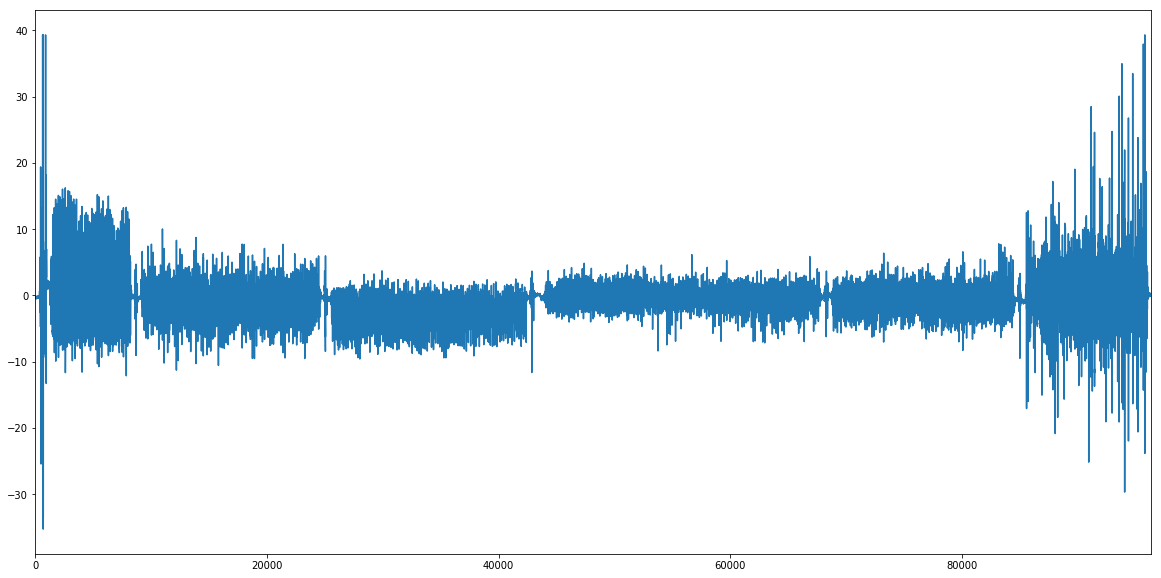

In [29]:
m['knee-r']['accY_knee-r'].plot(figsize=(20,10))

In [36]:
dataParentPath = os.path.join('..', 'data', '08-07-19')
subjectPaths = [folderTuple[0] for folderTuple in os.walk(dataParentPath)][1:]

def duplicateEachLine(file):
    source = open(file, 'r')
    target = open(file + '_fixed', 'w')
    
    for row in source:
        for iRow in range(2):
            target.write(row)
    source.close()
    target.close()
    os.remove(file)
    os.rename(file + '_fixed', file)

for subjectPath in subjectPaths:
    faultySensorFileName = list(filter(lambda fileName: 'I-WXB' in fileName, os.listdir(subjectPath)))[0]    
    duplicateEachLine(subjectPath + '/' + faultySensorFileName)